In [6]:
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import mlflux.gotm
from mlflux.gotm import read2010, predict, gen_epsilon_flux

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data of post 2010s
Coarsen from approximately hourly to 3-hourly. We have updated the read-in file to include all variables.

### Read in and select time range

In [8]:
# Path
path = '/home/jw8736/code-5.2.1/cases/ows_papa/'
df = read2010(path, datetimeformat='%Y-%m-%d %H:%M:%S')

# Interpolate to hourly
df_ = df.set_index('datetime')
ds = xr.Dataset.from_dataframe(df_)
ds_uniform = ds.resample(datetime='H').interpolate('linear') # Interpolation non-uniform to hourly
# ds_hat = ds_uniform.resample(datetime='3H').mean() # Coarsening to 3-hourly

# Select a range of dates
sd = '2012-03-21'; ed = '2012-05-20'
# sd = '2012-05-21'; ed = '2012-08-20'
# sd = '2012-08-21'; ed = '2013-01-10'
ds = ds_uniform.sel(datetime=slice(sd,ed))

In [9]:
ds

<xarray.Dataset>
Dimensions:   (datetime: 1464)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2012-03-21 ... 2012-05-20T23:00:00
Data variables: (12/15)
    sst       (datetime) float64 4.923 4.913 4.911 4.896 ... 6.401 6.403 6.412
    ux        (datetime) float64 9.071 2.482 0.4152 ... -6.143 -5.062 -4.975
    uy        (datetime) float64 4.974 6.641 -2.211 ... 1.346 1.637 0.03025
    t         (datetime) float64 0.8562 0.9447 1.634 1.046 ... 5.349 5.517 5.473
    p         (datetime) float64 1.001e+05 1e+05 ... 9.943e+04 9.936e+04
    q         (datetime) float64 0.003646 0.003893 ... 0.005672 0.005692
    ...        ...
    swr       (datetime) float64 168.8 98.01 155.3 45.05 ... 474.9 276.7 212.8
    lwr       (datetime) float64 -42.75 -28.61 -36.52 ... -15.84 -8.855 -8.974
    U         (datetime) float64 10.35 7.09 2.25 6.386 ... 6.288 5.32 4.975
    rh        (datetime) float64 89.7 95.02 95.77 95.59 ... 98.05 99.5 100.1
    cos       (datetime) float64 0.8768 0.3501 0.1846 ... -0.9768 -0.9515 -1.0
    sin       (datetime) float64 0.4808 0.9367 -0.9828 ... 0.214 0.3078 0.006079

### Apply ANN to compute fluxes and generate stochastic ensemble
There are still room for improvements for ANN

In [10]:
from mlflux.predictor import Fluxdiff # This is needed in the main. We will optimize later
ds = predict(ds)

Predicting fluxes and stds based on ANNs in directory /home/jw8736/mlflux/saved_model/one_output_anns/...
Finished!


In [45]:
T=60
dt=3
ENSEM=2
Q_eps_ensem = gen_epsilon_flux (ds, FLUX='heat', T=T, dt=dt, ENSEM=ENSEM)

Generating an ensemble of heat flux. Size=2.
Finished! eps_ensem array shape: (2, 1464)


Text(0, 0.5, '$Q_h+Q_l \\; (W/m^2)$')

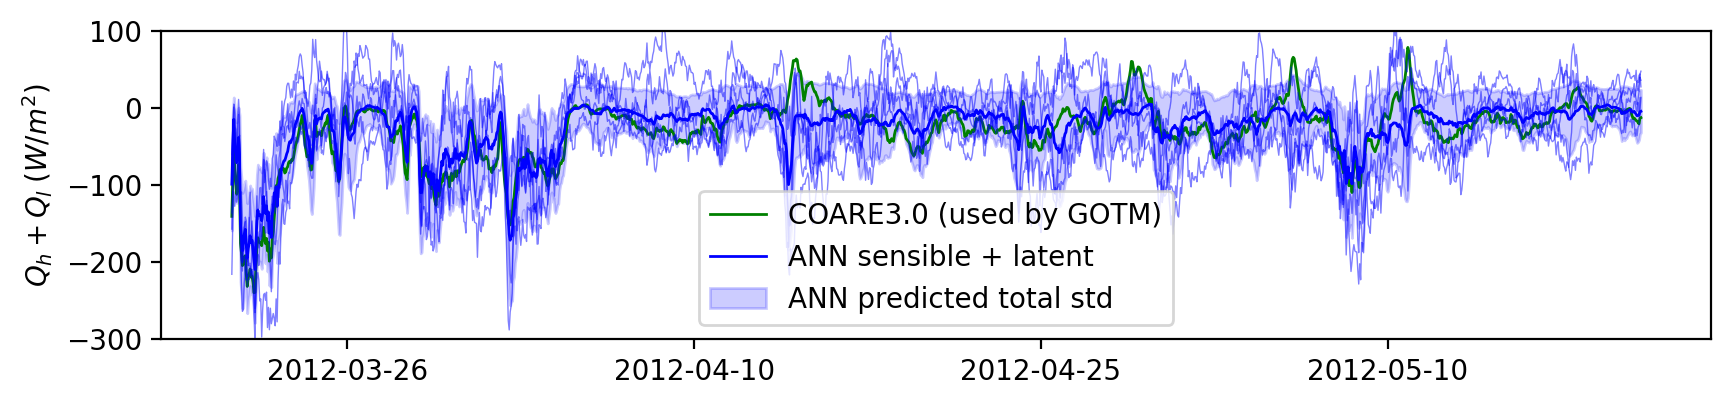

In [13]:
''' Heat flux '''
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

# Q-LWR from the flux data provided from GOTM
# computed from COARE3.0 (have tested this)
plt.plot(ds.datetime, ds.Q - ds.lwr, label='COARE3.0 (used by GOTM)', c='g', lw=1) 

# computed from ANNs
interval = (ds.qh_ann_sigma + ds.ql_ann_sigma)**0.5
mean = ds.qh_ann + ds.ql_ann 
plt.plot(ds.datetime, mean, label='ANN sensible + latent', color='blue', lw=1)
plt.fill_between(ds.datetime, mean-interval, mean+interval, 
                 color='blue', alpha=0.2, label='ANN predicted total std')

for i in range(0,ENSEM,20):
    plt.plot(ds.datetime, mean+Q_eps_ensem[i], lw=0.5, alpha=0.5, c='b')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.ylim([-300, 100]); plt.ylabel('$Q_h+Q_l \; (W/m^2)$')

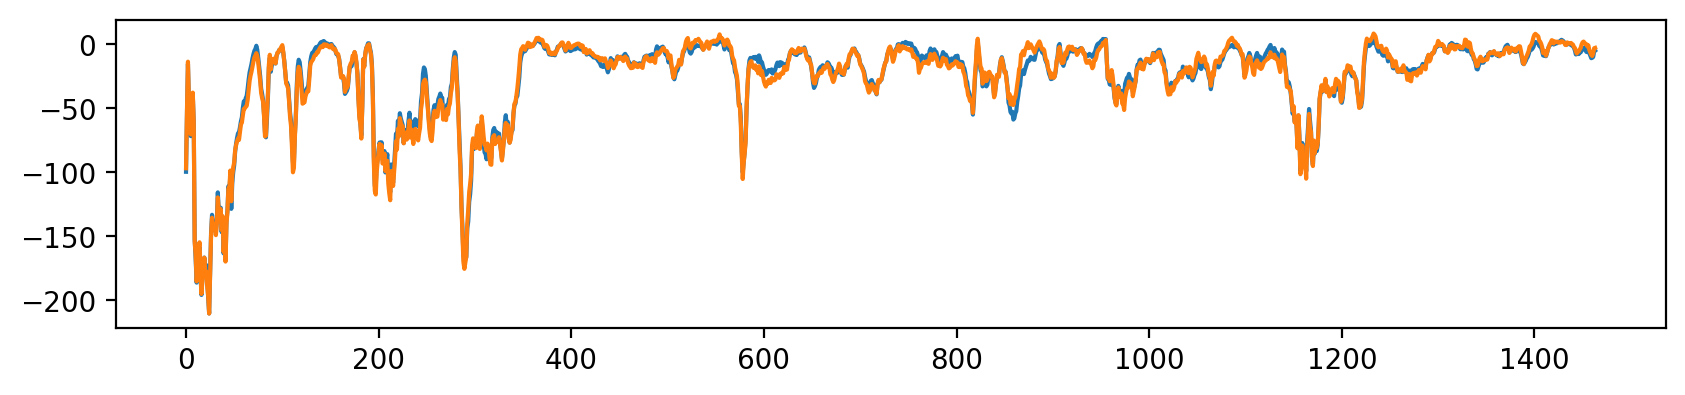

In [14]:
''' Difference between ensemble mean and ANN mean '''
Q_eps_mean = Q_eps_ensem.mean(axis=0)

fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()
plt.plot(mean)
plt.plot(mean+Q_eps_mean)

In [38]:
T=20
dt=3
ENSEM=1
taux_eps_ensem = gen_epsilon_flux (ds, FLUX='taux', T=T, dt=dt, ENSEM=ENSEM)

Generating an ensemble of taux flux. Size=1.
Finished! eps_ensem array shape: (1, 1464)


Text(0, 0.5, '$\\tau_x \\; (m^2/s^2)$')

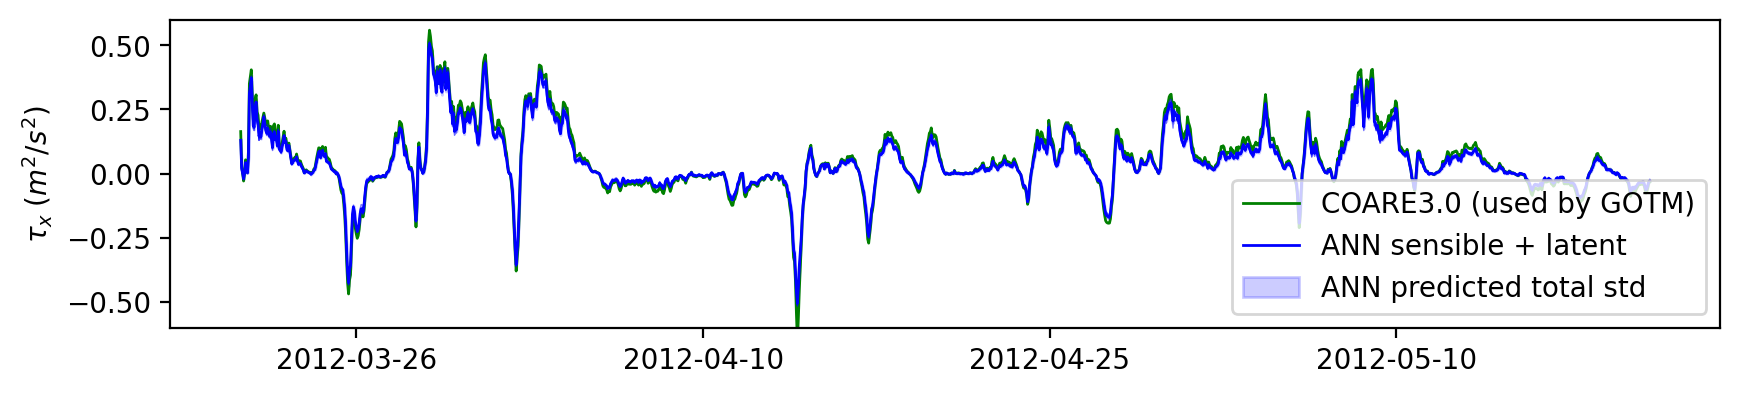

In [36]:
''' Momentum flux
    CHECK: the uncertainty seems a bit small. '''
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()

# Q-LWR from the flux data provided from GOTM
# computed from COARE3.0 (have tested this)
plt.plot(ds.datetime, ds.taux, label='COARE3.0 (used by GOTM)', c='g', lw=1) 

# computed from ANNs
interval = ds.taux_ann_sigma
mean = ds.taux_ann
plt.plot(ds.datetime, mean, label='ANN sensible + latent', color='blue', lw=1)
plt.fill_between(ds.datetime, mean-interval, mean+interval, 
                 color='blue', alpha=0.2, label='ANN predicted total std')

for i in range(0,ENSEM,20):
    plt.plot(ds.datetime, mean+taux_eps_ensem[i], lw=0.5, alpha=0.5, c='b')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.legend()
plt.ylim([-0.6,0.6]) 
plt.ylabel(r'$\tau_x \; (m^2/s^2)$')

### Write to file

In [61]:
from mlflux.gotm import write_stoch_flux
path = './'

if FLUX == 'heat':
    mean = ds.Q.values.reshape(-1,1) 
    eps_ensem = Q_eps_ensem.reshape(ENSEM, -1, 1) # of shape ensem*time*number_of_quantities_per_row
    write_stoch_flux (path=path, datetime=ds.datetime.values, mean=mean, eps_ensem=eps_ensem, prefix='heatflux_ann')

Finish writing to ./heatflux_ann_ensem1.dat
Finish writing to ./heatflux_ann_ensem2.dat
Finish writing to ./heatflux_ann_mean.dat
Finish writing to ./heatflux_ann_ensem_mean.dat


In [74]:
from mlflux.gotm import write_stoch_flux
path = './'
FLUX = 'momentum'
ENSEM = 4

taux_eps_ensem = gen_epsilon_flux (ds, FLUX='taux', T=T, dt=dt, ENSEM=ENSEM)
tauy_eps_ensem = gen_epsilon_flux (ds, FLUX='tauy', T=T, dt=dt, ENSEM=ENSEM)

if FLUX == 'momentum':
    mean1 = ds.taux.values
    mean2 = ds.tauy.values
    mean = np.concatenate((mean1[..., np.newaxis], mean2[..., np.newaxis]), axis=-1)
    eps_ensem = np.concatenate((taux_eps_ensem[..., np.newaxis], tauy_eps_ensem[..., np.newaxis]), axis=-1)  
    write_stoch_flux (path=path, datetime=ds.datetime.values, mean=mean, eps_ensem=eps_ensem, prefix='momentumflux_ann')    

Generating an ensemble of taux flux. Size=4.
Finished! eps_ensem array shape: (4, 1464)
Generating an ensemble of tauy flux. Size=4.
Finished! eps_ensem array shape: (4, 1464)
Finish writing to ./momentumflux_ann_ensem1.dat
Finish writing to ./momentumflux_ann_ensem2.dat
Finish writing to ./momentumflux_ann_ensem3.dat
Finish writing to ./momentumflux_ann_ensem4.dat
Finish writing to ./momentumflux_ann_mean.dat
Finish writing to ./momentumflux_ann_ensem_mean.dat


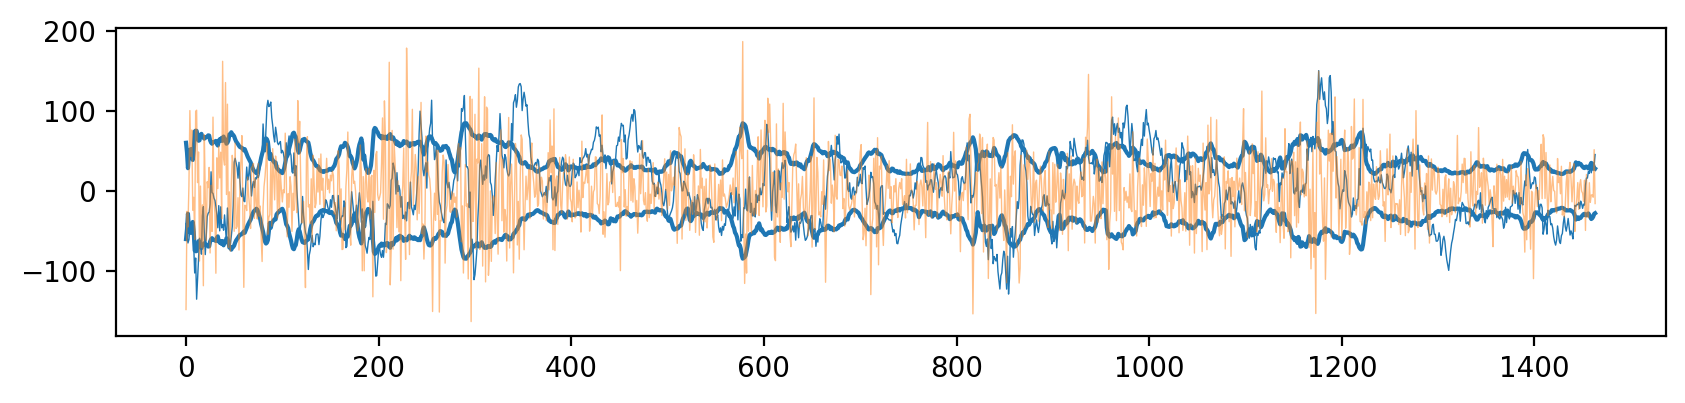

In [55]:
fig = plt.figure(figsize=[10,2], dpi=200); ax = plt.gca()
plt.plot(std, c='C0')
plt.plot(-std, c='C0')
plt.plot(epsilon, alpha=1, lw=0.5)
white = np.random.normal(loc=0, scale=std, size=std.shape)
plt.plot(white, alpha=0.5, lw=0.5)

In [72]:
# Specify the output file
path = '/home/jw8736/test-gotm/2012/'

output_file = path + 'heat_flux_3hourly_bulk.dat'
# Write the datetime and values to the file, row by row
with open(output_file, 'w') as file:
    for t, val in zip(ds_hat.t.values, ds_hat.Q.values):
        datetime_string = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
        file.write(f"{datetime_string}\t{val:.8f}\n")

output_file = path + 'momentum_flux_3hourly_bulk.dat'
with open(output_file, 'w') as file:
    for t, val1, val2 in zip(ds_hat.t.values, ds_hat.taux.values, ds_hat.tauy.values,):
        datetime_string = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
        file.write(f"{datetime_string}\t{val1:.8f}\t{val2:.8f}\n")

In [12]:
path = '/home/jw8736/test-gotm/2012/'
output_file = path + 'swr_3hourly_bulk.dat'
with open(output_file, 'w') as file:
    for t, val in zip(ds_hat.datetime.values, ds_hat.swr.values):
        datetime_string = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M:%S')
        file.write(f"{datetime_string}\t{val:.8f}\n")

In [ ]:
meteo_era5.dat
start: 2011-03-21 00:00:00           # start date and time [yyyy-mm-dd HH:MM:SS; default=2017-01-01 00:00:00]
stop: 2020-03-21 00:00:00            # stop date and time [yyyy-mm-dd HH:MM:SS; default=2018-01-01 00:00:00]

In [ ]:
# See timeseries.ipynb
# TODO: merge the two

### Check the two files

Text(0, 0.5, '$Q_{total} (W/m^2)$')

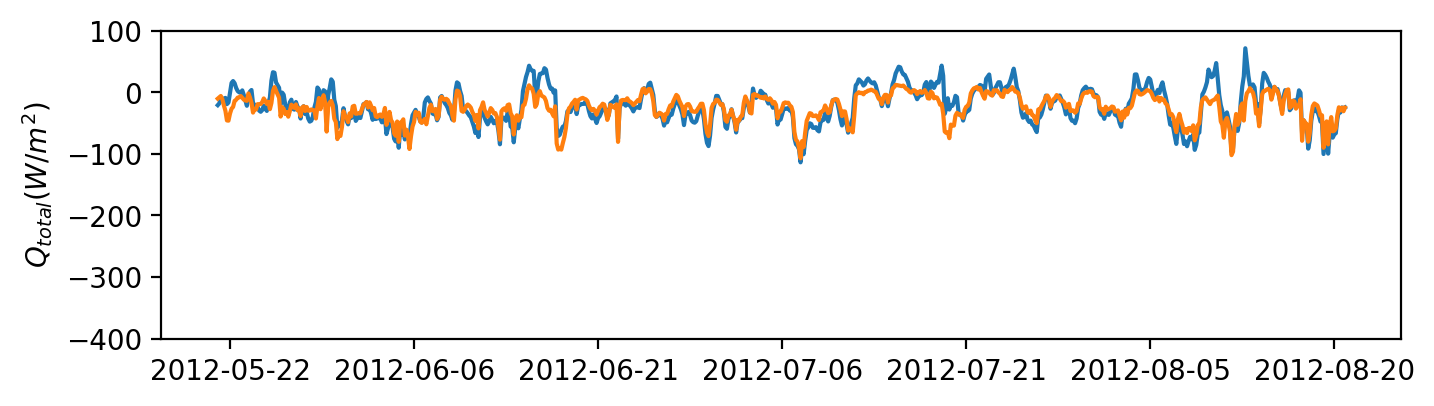

In [3]:
# Read the data file
# Adjust the file path as needed
path = '/home/jw8736/test-gotm/2012/'

heat_data_file = path + 'heat_flux_3hourly_bulk.dat'
momentum_data_file = path + 'momentum_flux_3hourly_bulk.dat'
df_bulk = read_fluxes(heat_data_file, momentum_data_file,
                 datetimeformat='%Y-%m-%d %H:%M:%S') 

heat_data_file = path + 'heat_flux_3hourly_ann.dat'
momentum_data_file = path + 'momentum_flux_3hourly_ann.dat'
df_ann = read_fluxes(heat_data_file, momentum_data_file,
                 datetimeformat='%Y-%m-%d %H:%M:%S') 


fig = plt.figure(figsize=[8,2],dpi=200)
ax = plt.gca()

# sd = '2012-03-21'; ed = '2012-05-20'
sd = '2012-05-21'; ed = '2012-08-20'

# Select data within the date range
ax.plot(df_bulk.t.sel(t=slice(sd, ed)), df_bulk.Q.sel(t=slice(sd, ed)), alpha=1, label='bulk')
ax.plot(df_ann.t.sel(t=slice(sd, ed)), df_ann.Q.sel(t=slice(sd, ed)), alpha=1, label='ann')

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))

ax.set_ylim(-400,100); plt.ylabel('$Q_{total} (W/m^2)$')
# plt.legend()

## Data of 1960s

In [ ]:
''' Older code '''
def read_fluxes (heat_data_file='heatflux.dat', momentum_data_file='momentumflux.dat',
                 datetimeformat='%Y/%m/%d %H:%M:%S'):

    # Use read_csv to read the file
    df1 = pd.read_csv(heat_data_file, sep='\s+', header=None, names=['date', 'time', 'Q'])
    # Combine the 'date' and 'time' columns into a single 'datetime' column
    df1['datetime'] = df1['date'] + ' ' + df1['time']
    # Convert 'datetime' column to datetime format
    df1['datetime'] = pd.to_datetime(df1['datetime'], format=datetimeformat)
    # Drop the separate 'date' and 'time' columns if they are no longer needed
    df1.drop(columns=['date', 'time'], inplace=True)
    # Combine the date and time columns if necessary
    # Ensure 'datetime' column is in the correct format
    df1['datetime'] = pd.to_datetime(df1['datetime'], format=datetimeformat)
    
    df2 = pd.read_csv(momentum_data_file, sep='\s+', header=None, names=['date', 'time', 'taux', 'tauy'])
    df2['datetime'] = df2['date'] + ' ' + df2['time']
    df2['datetime'] = pd.to_datetime(df2['datetime'], format=datetimeformat)
    df2.drop(columns=['date', 'time'], inplace=True)
    df2['datetime'] = pd.to_datetime(df2['datetime'], format=datetimeformat)

    df = pd.merge(df1, df2, on='datetime')
    df = df[['datetime','Q','taux','tauy']]
    
    xrdf = xr.Dataset(
    {'taux': (['t'], df.taux),
    'tauy': (['t'], df.tauy),
    'Q': (['t'], df.Q)},
    coords={
        "t": df.datetime,
    },)
    
    return xrdf
    
fig = plt.figure(figsize=[8,2],dpi=200)
ax = plt.gca()

df = read_fluxes(heat_data_file='heatflux.dat', momentum_data_file='momentumflux.dat',
                 datetimeformat='%Y/%m/%d %H:%M:%S')

Q_hat = df.Q.coarsen({'t':8}, boundary='trim').mean()
ax.plot(df.t[:1000], df.Q[:1000], alpha=0.5, label='3 hourly')
ax.plot(df.t[:1000:8], df.Q[:1000:8], c='C0', alpha=1, label='Sampling')
ax.plot(df.t[:1000:8], Q_hat[:125], '--', c='C0', alpha=1, label='Filtering')

ax.set_ylabel(r'Heat flux ($W/m^2$)')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend()
plt.show()

In [ ]:
time_ = df1['datetime'].dt.strftime('%Y/%m/%d %H:%M:%S')

# Merge DataFrames on their index (the "time" coordinate in this case)
Q_hat_pd = pd.merge(Q_hat.t.to_dataframe(), Q_hat.to_dataframe(), left_index=True, right_index=True)
Q_hat_pd.to_csv("heatflux_filter1day.txt", sep=' ', header=False, index=False)